Here we derive an implementation of the gates for the trace operator of $2\mathbb{O}$.

In [327]:
import numpy as np
import math
from math import sqrt as sqrt
import itertools as it
from qiskit import *
from qiskit.providers import aer
from qiskit import Aer
from qiskit.quantum_info import Operator, Statevector
from qiskit.visualization import plot_histogram
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp

import qiskit.tools.jupyter

We wish to apply the trace of each element as a phase on that element. Qiskit provides a function for changing the basis of an element into a basis of $Z$ operators. So we need only provide the diagnolized form of the operator we seek, and Qiskit magic does the rest. :)

We can do this naively with a full $48x48$ diagonal matrix, but this turns out to have unsatisfactory complexity characteristics. We provide it here as a point of comparison. Placing the traces (in the correct order!) into a diagonal matrix, Qiskit's \textit{SparsePauliOp.from_operator} returns the sum of tensors with $Z$ needed to produce it.

In [328]:
traces = [2.00000000000000, 1.00000000000000*sqrt(2), -1.00000000000000,
       -1.00000000000000*sqrt(2), -1.00000000000000, 0, 0, 0,
       0.000000000000000, 0, -1.00000000000000, -1.00000000000000*sqrt(2),
       1.00000000000000, 1.00000000000000*sqrt(2), 0, 0, 0, 0,
       -1.00000000000000, 0, 1.00000000000000, 0, 0, 0, 0,
       1.00000000000000*sqrt(2), 1.00000000000000, 0, -1.00000000000000,
       -1.00000000000000*sqrt(2), 0, 0, -2.00000000000000,
       -1.00000000000000*sqrt(2), 1.00000000000000,
       1.00000000000000*sqrt(2), 1.00000000000000, 0, 0, 0,
       0.000000000000000, 0, 1.00000000000000, 1.00000000000000*sqrt(2),
       -1.00000000000000, -1.00000000000000*sqrt(2), 0, 0, 0, 0,
       1.00000000000000, 0, -1.00000000000000, 0, 0, 0, 0,
       -1.00000000000000*sqrt(2), -1.00000000000000, 0, 1.00000000000000,
       1.00000000000000*sqrt(2), 0, 0]

trace_ham = np.diag(traces)
zbase_trace = SparsePauliOp.from_operator(trace_ham)

In [329]:
zbase_trace

SparsePauliOp(['ZIIIZI', 'ZIIIZZ', 'ZIIZZI', 'ZIIZZZ', 'ZIZIZI', 'ZIZIZZ', 'ZIZZZI', 'ZIZZZZ', 'ZZIIZI', 'ZZIIZZ', 'ZZIZII', 'ZZIZIZ', 'ZZIZZI', 'ZZIZZZ', 'ZZZIZI', 'ZZZIZZ', 'ZZZZII', 'ZZZZIZ', 'ZZZZZI', 'ZZZZZZ'],
              coeffs=[ 0.3017767+0.j, -0.0517767+0.j,  0.3017767+0.j, -0.0517767+0.j,
  0.125    +0.j,  0.125    +0.j,  0.125    +0.j,  0.125    +0.j,
  0.3017767+0.j, -0.0517767+0.j, -0.1767767+0.j,  0.1767767+0.j,
  0.125    +0.j,  0.125    +0.j, -0.125    +0.j, -0.125    +0.j,
  0.4267767+0.j,  0.0732233+0.j,  0.3017767+0.j, -0.0517767+0.j])

Its not clear due to the finite precision numbers, but through some trial and error we can show that the coffecients are 

$ 
\begin{align*}
  0.301 &= \frac{1}{8}(\sqrt{2} + 1)\\
  0.051 &= \frac{1}{8}(\sqrt{2} - 1)\\
  0.125 &= \frac{1}{8}\\
  0.176 &= \frac{\sqrt{2}}{8}\\
  0.426 &= \frac{1}{4}(1+\frac{\sqrt{2}}{2})\\
  0.073 &=  \frac{1}{4}(1-\frac{\sqrt{2}}{2})
\end{align*}
$



Now, thats a lot of gates. Since there are only 8 conjugacy classes in $2\mathbb{O}$ we dont actually need a $48x48$ matrix. It turns out 8 will do, provided we can collapse group elements to their classes. In fact we can, but we defer that discussion for now to focus on our simplified gate.

In [330]:
small_traces = [0, 0, 2, -2, 1, -1, sqrt(2), -sqrt(2)]
small_trace_mag = np.linalg.norm(small_traces)
small_trace_ham = np.diag(small_traces)
small_zbase_trace = SparsePauliOp.from_operator(small_trace_ham)

In [331]:
small_zbase_trace

SparsePauliOp(['IIZ', 'IZZ', 'ZIZ', 'ZZZ'],
              coeffs=[ 1.10355339+0.j, -0.60355339+0.j, -0.10355339+0.j, -0.39644661+0.j])

Much simpler! Only four terms in 3 qubits are needed. The coefficients are again delivered in an unfortunate way, but we can fiddle a bit to find that they are

$
\begin{align*}
1.103 &= \frac{1}{4}(3 + \sqrt{2})\\
0.103 &= \frac{1}{4}(1 - \sqrt{2})\\
0.603 &= \frac{1}{4}(1 + \sqrt{2})\\
0.396 &= \frac{1}{4}(3 - \sqrt{2})
\end{align*}
$

We can then implement this simpler calculation as a circuit.

In [332]:
c1=sqrt(2)/4 + 3/4
c2=-(sqrt(2)/4 + 1/4)
c3=-(sqrt(2)/4 - 1/4)
c4=sqrt(2)/4 - 3/4

Now we can put together a circuit for this gate, with the obserbation that

```
b1 ---*---------*---
      |         |
b2 --(+)--[Z]--(+)--
```

Is equivalent to $Z_{b_1} \otimes Z_{b_2}$.

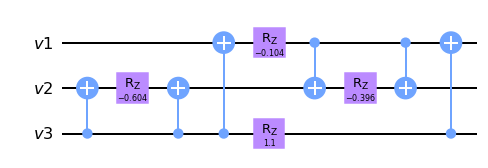

In [352]:
v1 = QuantumRegister(1,"v1")
v2 = QuantumRegister(1,"v2")
v3 = QuantumRegister(1,"v3")

traceGate = QuantumCircuit(v1,v2,v3, name=" [Trace Gate] ")

traceGate.cx(v3,v2)
traceGate.rz(c2,v2)
traceGate.cx(v3,v2)

traceGate.cx(v3,v1)
traceGate.rz(c3,v1)
traceGate.cx(v1,v2)
traceGate.rz(c4,v2)
traceGate.cx(v1,v2)
traceGate.rz(c1,v3)
traceGate.cx(v3,v1)

traceGate.draw("mpl")

Remark: This caused a great deal of confusion. There seems to be an inconsistency in how Qiskit reads bit orders. The permutation sending $(000, 001, 010, \dots)$ to $(000, 100, 010, \dots)$ is not easy to identify offhand if one is not expecting it.

We can use Qiskit to verify this is indeed the right circuit, by taking its matrix logorithm.

In [351]:
2j*np.log(np.diag(Operator(traceGate)))

array([ 0.        +0.00000000e+00j,  1.        -1.15157860e-16j,
        2.        +1.68427980e-16j,  1.41421356-6.08651736e-17j,
        0.        +0.00000000e+00j, -1.        -1.15157860e-16j,
       -2.        +1.68427980e-16j, -1.41421356-6.08651736e-17j])

And indeed, these are the traces we expect to see, in the right order. 

Next, we need to create the map sending each element to its class recorded in 3 bits; along with the inverse.
This is rather more straightforward. In the Sagemath document we derive polynomials for the first and second bits ($v_1$, $v_2$):

\begin{align*}
v_1 &= w_{2} w_{5} w_{6} + w_{2} w_{6} + w_{3} w_{4} w_{6} + w_{3} w_{6} + w_{4} w_{6} + w_{4} + w_{5} + w_{6}\\
v_2 &= w_{2} w_{3} w_{4} w_{6} + w_{2} w_{3} w_{4} + w_{2} w_{3} w_{5} w_{6} + w_{2} w_{3} w_{5} + w_{2} w_{3} w_{6}\\ 
&+ w_{2} w_{3} + w_{2} w_{4} w_{6} + w_{2} w_{4} + w_{2} w_{5} + w_{2} + w_{3} w_{4} + w_{3} w_{5} w_{6} + w_{3} w_{5}\\
&+ w_{3} + w_{4} w_{6} + w_{4} + w_{5} + 1
\end{align*}

(In $w$ rather than $x$)

In [353]:
x1 = QuantumRegister(1,"x1")
x2 = QuantumRegister(1,"x2")
x3 = QuantumRegister(1,"x3")
x4 = QuantumRegister(1,"x4")
x5 = QuantumRegister(1,"x5")
x6 = QuantumRegister(1,"x6")
v1 = QuantumRegister(1,"v1")
v2 = QuantumRegister(1,"v2")
v3 = QuantumRegister(1,"v3")

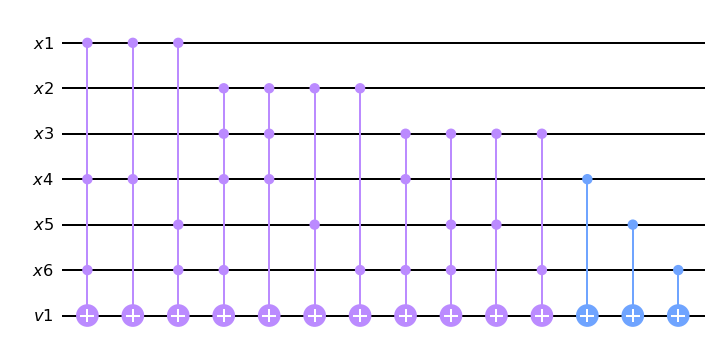

In [356]:
squishv1 = QuantumCircuit(x1,x2,x3,x4,x5,x6,v1, name=" [Squish v1] ")
# squishv1.mcx([x2,x3,x4,x6],v1)
# squishv1.mcx([x2,x3,x4],v1,v1)
# squishv1.mcx([x2,x3,x5,x6],v1)
# squishv1.mcx([x2,x3,x5],v1)
# squishv1.mcx([x2,x3,x6],v1)
# squishv1.mcx([x2,x3],v1)
# squishv1.mcx([x2,x4,x6],v1)
# squishv1.mcx([x2,x4],v1)
# squishv1.mcx([x2,x5],v1)
# squishv1.mcx([x2],v1)
# squishv1.mcx([x3,x4],v1)
# squishv1.mcx([x3,x5,x6],v1)
# squishv1.mcx([x3,x5],v1)
# squishv1.mcx([x3],v1)
# squishv1.mcx([x4,x6],v1)
# squishv1.mcx([x4],v1)
# squishv1.mcx([x5],v1)
# squishv1.x(v1)

squishv1.mcx([x1,x4,x6],v1)
squishv1.mcx([x1,x4],v1)
squishv1.mcx([x1,x5,x6],v1)
squishv1.mcx([x2,x3,x4,x6],v1)
squishv1.mcx([x2,x3,x4],v1)
squishv1.mcx([x2,x5],v1)
squishv1.mcx([x2,x6],v1)
squishv1.mcx([x3,x4,x6],v1)
squishv1.mcx([x3,x5,x6],v1)
squishv1.mcx([x3,x5],v1)
squishv1.mcx([x3,x6],v1)
squishv1.mcx([x4],v1)
squishv1.mcx([x5],v1)
squishv1.mcx([x6],v1)

squishv1.draw("mpl")


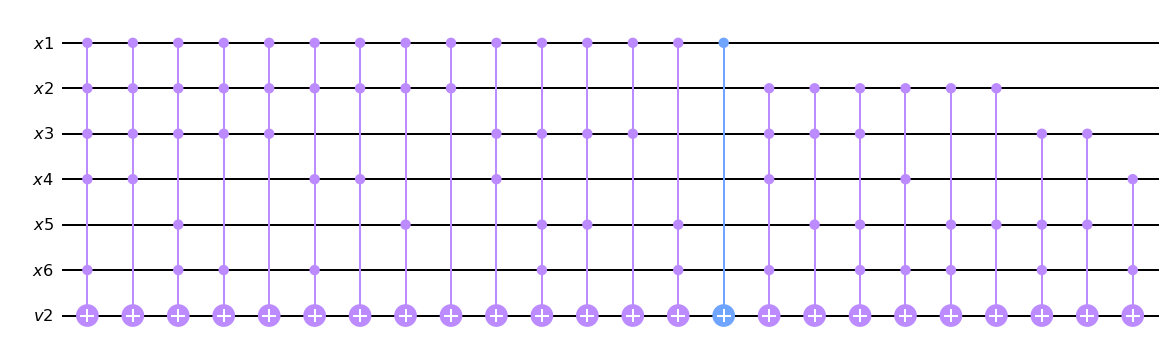

In [359]:
squishv2 = QuantumCircuit(x1,x2,x3,x4,x5,x6,v2, name=" [Squish v2] ")
# squishv2.mcx([x2,x3,x4,x6],v2)
# squishv2.mcx([x2,x3,x4],v2)
# squishv2.mcx([x2,x3,x5,x6],v2)
# squishv2.mcx([x2,x3,x5],v2)
# squishv2.mcx([x2,x3,x6],v2)
# squishv2.mcx([x2,x3],v2)
# squishv2.mcx([x2,x4,x6],v2)
# squishv2.mcx([x2,x4],v2)
# squishv2.mcx([x2,x5,x6],v2)
# squishv2.mcx([x2,x5],v2)
# squishv2.mcx([x2,x6],v2)
# squishv2.mcx([x2],v2)
# squishv2.mcx([x3,x4,x6],v2)
# squishv2.mcx([x3,x4],v2)
# squishv2.mcx([x3,x5,x6],v2)
# squishv2.mcx([x3,x5],v2)
# squishv2.mcx([x3,x6],v2)
# squishv2.mcx([x3],v2)
# squishv2.mcx([x6],v2)
# squishv2.x(v2)

squishv2.mcx([x1,x2,x3,x4,x6],v2)
squishv2.mcx([x1,x2,x3,x4],v2)
squishv2.mcx([x1,x2,x3,x5,x6],v2)
squishv2.mcx([x1,x2,x3,x6],v2)
squishv2.mcx([x1,x2,x3],v2)
squishv2.mcx([x1,x2,x4,x6],v2)
squishv2.mcx([x1,x2,x4],v2)
squishv2.mcx([x1,x2,x5],v2)
squishv2.mcx([x1,x2],v2)
squishv2.mcx([x1,x3,x4],v2)
squishv2.mcx([x1,x3,x5,x6],v2)
squishv2.mcx([x1,x3,x5],v2)
squishv2.mcx([x1,x3],v2)
squishv2.mcx([x1,x5,x6],v2)
squishv2.mcx([x1],v2)
squishv2.mcx([x2,x3,x4,x6],v2)
squishv2.mcx([x2,x3,x5],v2)
squishv2.mcx([x2,x3,x5,x6],v2)
squishv2.mcx([x2,x4,x6],v2)
squishv2.mcx([x2,x5,x6],v2)
squishv2.mcx([x2,x5],v2)
squishv2.mcx([x3,x5,x6],v2)
squishv2.mcx([x3,x5],v2)
squishv2.mcx([x4,x6],v2)

squishv2.draw("mpl")

In [361]:
squishv3 = QuantumCircuit(x1,x2,x3,x4,x5,x6,v3, name=" [Squish v3] ")

squishv3.mcx([x1,x2,x3,x4,x6],v3)
squishv3.mcx([x1,x2,x3,x4],v3)
squishv3.mcx([x1,x2,x3,x5,x6],v3)
squishv3.mcx([x1,x2,x3,x5],v3)
squishv3.mcx([x1,x2,x3,x6],v3)
squishv3.mcx([x1,x2,x3],v3)
squishv3.mcx([x1,x2,x4,x6],v3)
squishv3.mcx([x1,x2,x4],v3)
squishv3.mcx([x1,x2,x5],v3)
squishv3.mcx([x1,x2],v3)
squishv3.mcx([x1,x3,x4],v3)
squishv3.mcx([x1,x3,x5,x6],v3)
squishv3.mcx([x1,x3,x5],v3)
squishv3.mcx([x1,x3],v3)
squishv3.mcx([x1,x3],v3)
squishv3.mcx([x1,x3],v3)
squishv3.mcx([x1,x5,x6],v3)
squishv3.mcx([x1],v3)
squishv3.mcx([x2,x3,x5],v3)
squishv3.mcx([x2,x3,x6],v3)
squishv3.mcx([x2,x3],v3)
squishv3.mcx([x2,x4],v3)
squishv3.mcx([x2,x5,x6],v3)
squishv3.mcx([x2],v3)
squishv3.mcx([x3,x4],v3)
squishv3.mcx([x3],v3)
squishv3.mcx([x4],v3)
squishv3.mcx([x5],v3)
squishv3.x(v
              

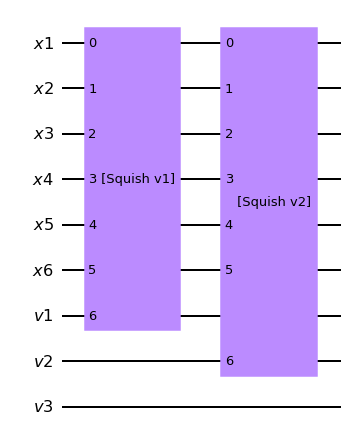

In [43]:
squish = QuantumCircuit(x1,x2,x3,x4,x5,x6,v1,v2,v3, name=" [Squish Gate] ")
squish.append(squishv1, [x1,x2,x3,x4,x5,x6,v1])
squish.append(squishv2, [x1,x2,x3,x4,x5,x6,v2])
squish.draw("mpl")

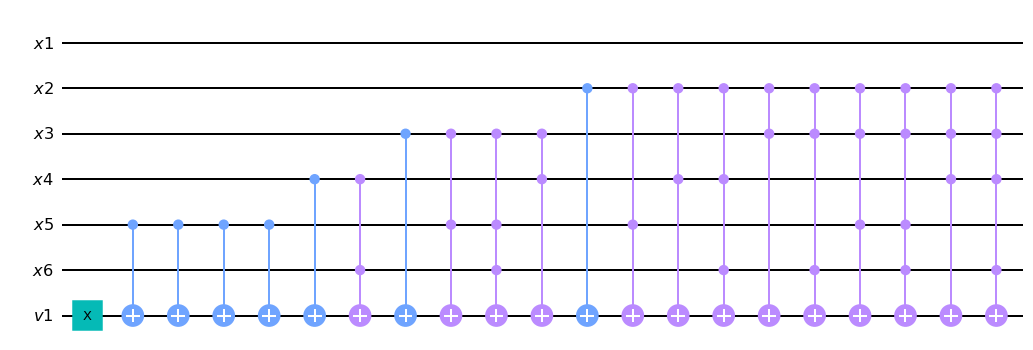

In [52]:
inv_squishv1 = QuantumCircuit(x1,x2,x3,x4,x5,x6,v1, name=" [Inverse Squish v1] ")

inv_squishv1.x(v1)
inv_squishv1.mcx([x5],v1)
inv_squishv1.mcx([x5],v1)
inv_squishv1.mcx([x5],v1)
inv_squishv1.mcx([x5],v1)
inv_squishv1.mcx([x4],v1)
inv_squishv1.mcx([x4,x6],v1)
inv_squishv1.mcx([x3],v1)
inv_squishv1.mcx([x3,x5],v1)
inv_squishv1.mcx([x3,x5,x6],v1)
inv_squishv1.mcx([x3,x4],v1)
inv_squishv1.mcx([x2],v1)
inv_squishv1.mcx([x2,x5],v1)
inv_squishv1.mcx([x2,x4],v1)
inv_squishv1.mcx([x2,x4,x6],v1)
inv_squishv1.mcx([x2,x3],v1)
inv_squishv1.mcx([x2,x3,x6],v1)
inv_squishv1.mcx([x2,x3,x5],v1)
inv_squishv1.mcx([x2,x3,x5,x6],v1)
inv_squishv1.mcx([x2,x3,x4],v1,v1)
inv_squishv1.mcx([x2,x3,x4,x6],v1)

inv_squishv1.draw("mpl")

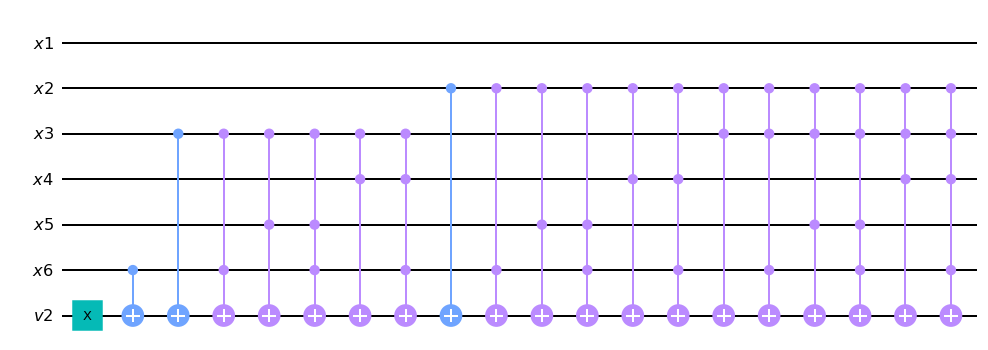

In [53]:
inv_squishv2 = QuantumCircuit(x1,x2,x3,x4,x5,x6,v2, name=" [Inverse Squish v2] ")

inv_squishv2.x(v2)
inv_squishv2.mcx([x6],v2)
inv_squishv2.mcx([x3],v2)
inv_squishv2.mcx([x3,x6],v2)
inv_squishv2.mcx([x3,x5],v2)
inv_squishv2.mcx([x3,x5,x6],v2)
inv_squishv2.mcx([x3,x4],v2)
inv_squishv2.mcx([x3,x4,x6],v2)
inv_squishv2.mcx([x2],v2)
inv_squishv2.mcx([x2,x6],v2)
inv_squishv2.mcx([x2,x5],v2)
inv_squishv2.mcx([x2,x5,x6],v2)
inv_squishv2.mcx([x2,x4],v2)
inv_squishv2.mcx([x2,x4,x6],v2)
inv_squishv2.mcx([x2,x3],v2)
inv_squishv2.mcx([x2,x3,x6],v2)
inv_squishv2.mcx([x2,x3,x5],v2)
inv_squishv2.mcx([x2,x3,x5,x6],v2)
inv_squishv2.mcx([x2,x3,x4],v2)
inv_squishv2.mcx([x2,x3,x4,x6],v2)

inv_squishv2.draw("mpl")

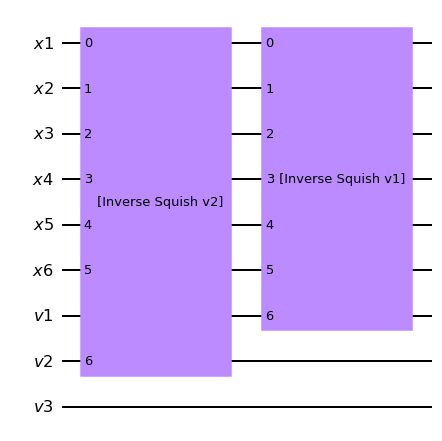

In [55]:
inv_squish = QuantumCircuit(x1,x2,x3,x4,x5,x6,v1,v2,v3, name=" [Inverse Squish Gate] ")
inv_squish.append(inv_squishv2, [x1,x2,x3,x4,x5,x6,v2])
inv_squish.append(inv_squishv1, [x1,x2,x3,x4,x5,x6,v1])
inv_squish.draw("mpl")

In [ ]:
# v1 = QuantumRegister(1,"v1")
# v2 = QuantumRegister(1,"v2")
# v3 = QuantumRegister(1,"v3")

# traceGate = QuantumCircuit(v1,v2,v3, name=" [$trace$ Gate] ")

# traceGate.rz(c4,v1)
# traceGate.cx(v1,v2)
# traceGate.rz(c3,v1)
# traceGate.cx(v1,v3)
# traceGate.rz(c2,v2)
# traceGate.rz(c1,v3)


# traceGate.draw("mpl")

In [ ]:
c4

In [ ]:
sqrt(2)/4 - 1/4

In [ ]:
d1 = 1
d2 = sqrt(2)
d3 = 2

v1 = QuantumRegister(1,"v1")
v2 = QuantumRegister(1,"v2")
v3 = QuantumRegister(1,"v3")

traceGate = QuantumCircuit(v1,v2,v3, name=" [$trace$ Gate] ")

traceGate.cx(v1,v3)
traceGate.rz(sqrt(2)+1,v3)
traceGate.rz(-sqrt(2),v1)
traceGate.rz(1,v2)
traceGate.cx(v3,v2)
traceGate.rz(-sqrt(2)-1,v3)
traceGate.cx(v1,v3)



traceGate.draw("mpl")

In [44]:
backend_sim = Aer.get_backend('aer_simulator')

(b1,b2,b3) = ([0,0] for n in range(0,3))
                                            
                       
results = {}
                       
for n in range(0,8):
    (_,_,vv1,vv2,vv3) = format(n, '#05b')
    (vv1,vv2,vv3) = map(int,(vv1,vv2,vv3))
    
    b1[vv1] = 1
    b1[(vv1 + 1) % 2] = 0 
    
    b2[vv2] = 1
    b2[(vv2 + 1) % 2] = 0 
    
    b3[vv3] = 1
    b3[(vv3 + 1) % 2] = 0 
    
    traceGate.initialize(b1, v1)
    traceGate.initialize(b2, v2)
    traceGate.initialize(b3, v3)
    
    traceGate.measure_all()
    
    job_sim = backend_sim.run(transpile(traceGate, backend_sim), shots=1)
    result_sim = job_sim.result()
    counts = result_sim.get_counts()
    results[n] = list(counts)[0][::-1]

In [45]:
counts

{'111 011 101 001 110 010 100 000': 1}